# Shape Analysis Examples

Here, we use the code in https://github.com/LittleAri/shapeClassification to perform elastic shape analysis on outlines from images.

### Contours
The main datasource is a folder of images. You can use the code in shapeClassification/contourExtraction to extract outlines (though note that this was based on a dataset of Greek vases so it may differ). Alternatively, the code in this notebook just uses a basic combination of Otsu thresholding and Marching Squares to extract the contours. It then focuses on the longest (number of points) contours and assumes that that is the outline of interest.

If you don't wish to use images at all, you can skip over to the relevant parts and upload your dataset.

### Tasks

1. Contour Extraction
1. Karcher means and Tangent PCA
1. Geodesic distances between all contours
1. KNN classification based on distance matrix -- bootstrapped through different combinations of training/testing sets.

### Shape Analysis

Please refer to [fdasrsf](https://fdasrsf-python.readthedocs.io/en/latest/) for the shape analysis code.

#### Imports

In [1]:
import numpy as np
from skimage.filters import threshold_otsu
from skimage import measure
import skimage.io as io
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import os
from pathlib import Path

## Step 0 -- Data Preparation

### Data Loading

In [2]:
# THINGS TO EDIT
##################

#############################################################
path_to_images = '../tests' # species separated into folders  ##
path_to_index = '../test_index.csv'                           ##
#############################################################

10 images in total


In [3]:
image_index = pd.read_csv(path_to_index)

all_image_paths = []
all_filenames = []
for folder in os.listdir(path_to_images):
    try:
        new_path = path_to_images+'/'+folder
        for file in os.listdir(new_path):
            all_image_paths.append(new_path+'/'+file)
            all_filenames.append(file)
    except:
        pass
        
print(str(len(all_image_paths))+" images in total")
total_images = len(all_image_paths)

### Folders

In [6]:
DATA_DIR = Path('../shape_results')

OUTPUT_DIR = DATA_DIR / 'Karcher_means'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = DATA_DIR / 'tpca'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = DATA_DIR / 'geodesic_distances'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = DATA_DIR / 'contours'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = DATA_DIR / 'knn'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## Step 1 -- Contour Extraction

### Single Test

#### Image Loading

In [7]:
# Image loading
k_index = 3
image_colour = io.imread(all_image_paths[k_index])
image_grey = io.imread(all_image_paths[k_index],as_gray=True)

#### Contour Extraction

In [8]:
# Binarize and contour extraction
thresh = threshold_otsu(image_grey)
binary = image_grey > thresh
contours = measure.find_contours(binary, 0.8)

#### Example Plots

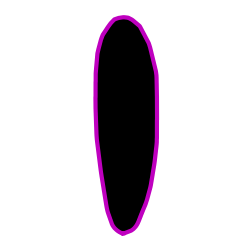

In [9]:
# Example plot

fig,ax = plt.subplots(figsize=(3,3))
ax.imshow(image_colour)
ax.axis('off')

for c in contours:
    ax.plot(c[:,1],c[:,0])
    
# Plot longest (no. points) contour against all contours
k_longest = np.argmax([len(c[:,0]) for c in contours])
x = contours[k_longest][:,1]
y = contours[k_longest][:,0]

ax.plot(x,y,'-m',lw=3)

### Contour Extraction Loop

#### Functions / Imports

In [10]:
def find_contours_from_image(greyscaled_image):
    thresh = threshold_otsu(greyscaled_image)
    binary = greyscaled_image > thresh
    contours = measure.find_contours(binary, 0.8)
    k_longest = np.argmax([len(c[:,0]) for c in contours])
    x = contours[k_longest][:,1]
    y = contours[k_longest][:,0]
    return x,y

In [11]:
# Reparametrize and rescale functions

from contourExtraction.objSymmetrize import reparam, rescale

#### Contour Finding

In [12]:
all_contours = []

number_of_points = 100

for i,path in enumerate(all_image_paths):
    file = all_filenames[i]
    species = image_index[image_index['Filename']==all_filenames[i]]['Class'].iloc[0]
    ID = image_index[image_index['Filename']==all_filenames[i]]['Index'].iloc[0]
    image_grey = io.imread(path,as_gray=True)
    x,y = find_contours_from_image(image_grey)
    xr,yr = reparam(x,y,number_of_points)
    xs,ys = rescale(xr,yr)
    all_contours.append([[ID]*number_of_points,[file]*number_of_points,[species]*number_of_points,xs,ys])

#### Dataframe of Contours

In [13]:
contours_table = pd.DataFrame()
size_ = total_images * number_of_points

contours_table['Index'] = list(np.array(all_contours)[:,0,:].reshape(size_,1).flatten())
contours_table['Filename'] = list(np.array(all_contours)[:,1,:].reshape(size_,1).flatten())
contours_table['Species'] = list(np.array(all_contours)[:,2,:].reshape(size_,1).flatten())
contours_table['X'] = list(np.float_(np.array(all_contours)[:,3,:]).reshape(size_,1).flatten())
contours_table['Y'] = list(np.float_(np.array(all_contours)[:,4,:]).reshape(size_,1).flatten())

In [14]:
contours_table.to_csv('../shape_results/contours/contours_table.csv',index=False)

## Step 2 -- Karcher Means

#### Imports

In [15]:
from KarcherMean.tPCA_KarcherMean import align
from KarcherMean.tPCA_KarcherMean import formatData
from KarcherMean.tPCA_KarcherMean import rescale

### Data Preparation

In [17]:
# contours_table = pd.read_csv('../shape_results/contours/contours_table.csv')

all_groups = np.unique(list(contours_table['Species'])) # or whichever classes you are focusing on.

### Karcher Means / tPCA per Specie

In [19]:
for group in tqdm.tqdm(all_groups):
    # Filter dataset for group:
    newdf = contours_table[contours_table['Species'].isin([group])]
    names = list(pd.unique(newdf['Filename']))
    beta = formatData(newdf,varName="Filename", xName="X", yName="Y")
    # Compute Karcher mean / tPCA:
    algn,km,tpca = align(beta,returnDF=1)
    # Save results:
    tpca.index=names
    tpca.index.name='Filename'
    newname = str(group)#"_".join(re.findall('\w+',group))
    tpca.to_csv('../shape_results//tpca/tPCA_'+newname+'.csv')
    km.to_csv('../shape_results/Karcher_means/KarcherMean_'+newname+'.csv',index=False)

  0%|                                                                   | 0/3 [00:00<?, ?it/s]

Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3


 33%|███████████████████▋                                       | 1/3 [00:01<00:02,  1.29s/it]

Computing Karcher Mean of 4 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5


 67%|███████████████████████████████████████▎                   | 2/3 [00:03<00:01,  1.66s/it]

Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3


100%|███████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.50s/it]


### Karcher Mean of Total Sample

In [20]:
names = list(pd.unique(contours_table['Filename']))
beta = formatData(contours_table,varName="Filename", xName="X", yName="Y")
# Compute Karcher mean / tPCA:
algn,km,tpca = align(beta,returnDF=1)
# Save results:
tpca.index=names
tpca.index.name='Filename'
tpca.to_csv('../shape_results/tpca/tPCA_all.csv')
km.to_csv('../shape_results/Karcher_means/KarcherMean_all.csv',index=False)

Computing Karcher Mean of 10 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5
updating step: 6


#### Example Plot

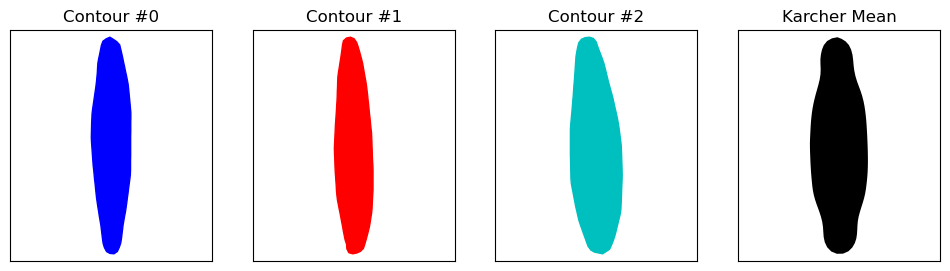

In [22]:
fig,ax = plt.subplots(1,4,figsize=(12,3))


cols = ['b','r','c']
for p in range(3):
    ax[p].fill(beta[0,:,p],beta[1,:,p],'-',color=cols[p])
    ax[p].set_title('Contour #'+str(p))

ax[3].fill(km['x'],km['y'],'-k')
ax[3].set_title('Karcher Mean')

for i in range(0,4):
    ax[i].set_xlim([-1.6,1.6])
    ax[i].set_ylim([-1.6,1.6])
    ax[i].set_xticks([])
    ax[i].set_yticks([])


## Step 3 -- Geodesic Distances

#### Imports

In [23]:
from geodesicDistances.geodesicDistances import geodDistance

### Data Preparation

In [24]:
## If data not already loaded:
# pth = '../shape_results/contours/contours_table.csv'
# df = pd.read_csv(pth)
# names = np.unique(list(df['Filename']))

## If data loaded:
n = len(names)
df = deepcopy(contours_table)
print(str(n)+" contours in dataset.")

10 contours in dataset.


### Distance Table Computation

In [25]:
distances = np.zeros((n,n))
errors = []

for i in tqdm.tqdm(range(0,n)):
    x1 = list(df[df['Filename']==names[i]]['X'])
    y1 = list(df[df['Filename']==names[i]]['Y'])
    for j in range(i+1,n):
        x2 = list(df[df['Filename']==names[j]]['X'])
        y2 = list(df[df['Filename']==names[j]]['Y'])
        try:
            d,_,_,_ = geodDistance(x1,y1,x2,y2,k=5)
        except:
            try:
                d,_,_,_ = geodDistance(x2,y2,x1,y1,k=5)
            except:
                print("Error for contours "+str(i)+" and "+str(j))
                errors.append([i,j])
                d = 100000
        distances[i,j] = d
        distances[j,i] = d

print("Computed distances between "+str(n)+" contours, with "+str(len(errors))+" errors.")

100%|█████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.45it/s]

Computed distances between 10 contours, with 0 errors.


### Saving Data

In [26]:
distancesDF = pd.DataFrame(distances,index=names)
distancesDF.columns = names
distancesDF.index.name='Name'
distancesDF.to_csv('../shape_results/geodesic_distances/distances.csv')

In [27]:
distancesDF.head()

,Amos Lake 1_6.jpg_0.png,Amos Lake 1_7.jpg_0.png,Amos Lake 1_7.jpg_2.png,Amos_1990_1.jpg_0.png,Amos Lake 3_3.jpg_0.png,Amos Lake 3_2.jpg_3.png,Amos Lake 3_1.jpg_0.png,Amos Lake 1_6.jpg_1.png,Amos Lake 3_5.jpg_0.png,Amos Lake 1_6.jpg_2.png
Name,,,,,,,,,,
Amos Lake 1_6.jpg_0.png,0.000000,0.068538,0.100795,0.124674,0.108518,0.133392,0.125182,0.254026,0.232722,0.265767
Amos Lake 1_7.jpg_0.png,0.068538,0.000000,0.088617,0.131216,0.114504,0.134011,0.138997,0.258839,0.218080,0.282215
Amos Lake 1_7.jpg_2.png,0.100795,0.088617,0.000000,0.077181,0.058596,0.062157,0.072697,0.183449,0.161650,0.192049
Amos_1990_1.jpg_0.png,0.124674,0.131216,0.077181,0.000000,0.054549,0.057365,0.078876,0.145847,0.122482,0.147693
Amos Lake 3_3.jpg_0.png,0.108518,0.114504,0.058596,0.054549,0.000000,0.052585,0.074353,0.167892,0.154677,0.180983


## Step 4 -- KNN Classification on Geodesic Distances

#### Imports

In [2]:
from KNN_Classification.KNN_distanceMatrix import *

### Data

In [3]:
## Uncomment if not already loaded:
image_index = pd.read_csv('test_index.csv')
distancesDF = pd.read_csv('../shape_results/geodesic_distances/distances.csv')
classType = int #NOTE: if you're classes are integers e.g. Species 1-10, then write int, else, if they're strings, write str

############################################
classes = np.unique(list(image_index['Class']))

### KNN Bootstrapping

In [4]:
results = KNN_Bootstrapping(
    image_index,
    distancesDF,
    classes,
    nBootstrapping=3, # default 50
    classType=classType, # default str
    trainingProportion=0.5, # default 0
    kNeighbours=np.int_(np.linspace(1, 4, 4)), # default 3...12
    nameVariable="Filename", # default is Name
    classVariable="Class") # same as default


In [7]:
results.keys()

dict_keys(['topF1Score', 'topClassification', 'topTrainingTesting', 'allF1Scores', 'allTopNeighbours', 'allTrainingSamples', 'allClassificationResults'])

In [12]:
pd.DataFrame(results['topClassification']).head()

,Name,predictedClass,actualClass
0,Amos Lake 1_6.jpg_0.png,1,1
1,Amos Lake 1_7.jpg_2.png,2,1
2,Amos Lake 1_6.jpg_1.png,2,2
3,Amos Lake 1_6.jpg_2.png,2,2
4,Amos Lake 3_2.jpg_3.png,3,3


In [5]:
results['topTrainingTesting']

{'train': ['Amos Lake 1_7.jpg_0.png',
  'Amos Lake 3_1.jpg_0.png',
  'Amos Lake 3_5.jpg_0.png',
  'Amos_1990_1.jpg_0.png'],
 'test': ['Amos Lake 1_6.jpg_0.png',
  'Amos Lake 1_7.jpg_2.png',
  'Amos Lake 1_6.jpg_1.png',
  'Amos Lake 1_6.jpg_2.png',
  'Amos Lake 3_2.jpg_3.png',
  'Amos Lake 3_3.jpg_0.png']}

In [6]:
results['allF1Scores']

array([[0.82222222, 0.82222222, 0.66666667]])

In [13]:
# Save what you like:
pd.DataFrame(results['topClassification']).to_csv('../shape_results/knn/top_knn_classification.csv',index=False)
np.save('../shape_results/knn/top_knn_training_testing_split.npy',results['topTrainingTesting'])